# Fine-tuning a Wav2vec Model for Automatic Speech Recognition

**Name**: 

The ASR system used in the first two labs relied on an acoustic model made up of two main components: a *feature* extractor (based on the [wav2vec](https://arxiv.org/pdf/2006.11477) architecture) and a *classifier* (a linear layer). The model then operates in two stages:

1. The speech waveform is passed to the feature extractor to transform it into a latent representation (= the *feature maps*).
2. The latent representation is passed to a classification layer to compute the probability of each character (= the *emission matrix*).

<center><img src="https://github.com/magronp/magronp.github.io/blob/master/images/wav2vec2asr.png?raw=true" width="800"></center>

To train such a model in practice, a two-stage proces is used. First, the wav2vec model alone is pre-trained in a self-supervised manner (using speech data only). Then, the classification layer is added and the whole model \{wav2vec+classifier\} is fine-tuned in a supervised manner (from speech+transcript data).

In the previous labs, we have used a whole model that was already pre-trained and fine-tuned for ASR. In this lab, we start from the pre-trained wav2vec model, and we reproduce the process of fine-tuning it for ASR. 

In [135]:
import torch
from torch import nn
from torch.utils.data import Dataset
import torchaudio
import IPython
import os
import fnmatch
import copy
import matplotlib.pyplot as plt
torch.random.manual_seed(0);

MAX_FILES = 100 # lower this number for processing a subset of the dataset

In [136]:
# Main dataset path - Only change it HERE if needed and not later in the notebook
data_dir = "../dataset/"

In [137]:
# Speech and transcripts sub-directories paths
data_speech_dir = os.path.join(data_dir, 'speech')
data_transc_dir = os.path.join(data_dir, 'transcription')

## Preparation

In [138]:
# Example file
audio_file = '61-70968-0001.wav'
audio_file_path = os.path.join(data_speech_dir, audio_file)
print(f"Audio file path: {audio_file_path}")

waveform, sr = torchaudio.load(audio_file_path, channels_first=True)
IPython.display.Audio(data=waveform, rate=sr)

Audio file path: ../dataset/speech/61-70968-0001.wav


In [139]:
# Function to load a transcript; the preprocessing here is a bit different than in previous labs (more convenient for training)
def get_true_transcript(transc_file_path):
    with open(transc_file_path, "r") as f:
        true_transcript = f.read()
    true_transcript = true_transcript.lower().replace(' ','|').replace('\n','')
    return true_transcript

# Load and display the true transcription
transc_file_path = os.path.join(data_transc_dir, audio_file.replace('wav', 'txt'))
true_transcript = get_true_transcript(transc_file_path)
print(true_transcript)

give|not|so|earnest|a|mind|to|these|mummeries|child


In [140]:
# We provide the list of labels (=characters) that can be found in the dataset
labels = ['-', '|', 'e', 't', 'a', 'o', 'n', 'i', 'h', 's', 'r', 'd', 'l', 'u', 'm',
          'w', 'c', 'f', 'g', 'y', 'p', 'b', 'v', 'k', "'", 'x', 'j', 'q', 'z']
n_labels = len(labels)

We need to transform the true transcript into a list of integers in order to feed it to a training loss function. To that end, we define a dictionary `dico_labels` that maps each character in the list of possible labels to an integer (for instance, `dico_labels['e']=2` or `dico_labels['a']=4`).

In [141]:
# TODO: using the 'labels' list above, define this dictionary
dico_labels = {labels[i]:i for i in range(n_labels)}
print(dico_labels)

{'-': 0, '|': 1, 'e': 2, 't': 3, 'a': 4, 'o': 5, 'n': 6, 'i': 7, 'h': 8, 's': 9, 'r': 10, 'd': 11, 'l': 12, 'u': 13, 'm': 14, 'w': 15, 'c': 16, 'f': 17, 'g': 18, 'y': 19, 'p': 20, 'b': 21, 'v': 22, 'k': 23, "'": 24, 'x': 25, 'j': 26, 'q': 27, 'z': 28}


In [142]:
# Apply dico_labels to the true transcript, and build a tensor from it
target_indices = [dico_labels[c] for c in true_transcript]
target_indices = torch.tensor(target_indices, dtype=torch.long)
print(target_indices)

tensor([18,  7, 22,  2,  1,  6,  5,  3,  1,  9,  5,  1,  2,  4, 10,  6,  2,  9,
         3,  1,  4,  1, 14,  7,  6, 11,  1,  3,  5,  1,  3,  8,  2,  9,  2,  1,
        14, 13, 14, 14,  2, 10,  7,  2,  9,  1, 16,  8,  7, 12, 11])


## Acoustic model

Torchaudio comprises many models whose pretrained weights can be loaded directly (the list can be found [here](https://pytorch.org/audio/stable/pipelines.html#id3)). Here we use `WAV2VEC2_BASE`, which is pre-trained on speech data, but not fine-tuned for ASR.

We can apply it to the waveform to compute the feature maps, which is a tensor of size `[1, time steps, feature dim]` (recall that `1` corresponds to the batch size).

In [143]:
# Load the acoustic model: here it's a Wav2vec that is not fine-tuned
model_name = 'WAV2VEC2_BASE'
bundle = getattr(torchaudio.pipelines, model_name)
wav2vec = bundle.get_model()

# Display model architecture
print(wav2vec)

Wav2Vec2Model(
  (feature_extractor): FeatureExtractor(
    (conv_layers): ModuleList(
      (0): ConvLayerBlock(
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      )
      (1-4): 4 x ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (5-6): 2 x ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      )
    )
  )
  (encoder): Encoder(
    (feature_projection): FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (pos_conv_embed): ConvolutionalPositionalEmbedding(
        (conv): ParametrizedConv1d(
          768, 768, kernel_size=(128,), stride=(1,), padding=(64,), groups=16
          (parametriza

In [144]:
# Compute the feature maps
with torch.inference_mode():
    features, _ = wav2vec(waveform)

print(features.shape)

torch.Size([1, 180, 768])


<span style="color:red"> **Exercise 1**</span>. Complete the `Wav2vecASR` model class below. This model includes a wav2vec feature extractor (loaded above) and a linear classification layer that takes the feature maps and output log-probabilities per class (thus it has to use a [log softmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html) activation after classification).

In [145]:
class Wav2vecASR(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.feature_extractor = wav2vec
        self.linear_classifier = nn.Linear(768, output_size)
        self.softmax = nn.Softmax(dim=2)


    def forward(self, x):
        x, _ = self.feature_extractor(x)
        x = self.linear_classifier(x)
        x = self.softmax(x)
        return x


In [146]:
# Instanciate the model
output_size = n_labels
model = Wav2vecASR(output_size)

In [147]:
# A function to count the number of trainable parameters
def count_tlearnable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Number of trainable parameters:', count_tlearnable_params(model))

Number of trainable parameters: 94393245


The model is very large (90M+ parameters) mostly because of the wav2vec part. To speed training in this lab, we freeze the wav2vec part and we only train the classification layer. To that end, we need to set `requires_grad = False` for the wav2vec's parameters.

In [148]:
# TODO: Define a function to freeze parameters, apply it to "wav2vec" part of the model,
# and print the new number of trainable parameters

def freeze_params(model):
    for param in model.parameters():
        param.requires_grad = False

freeze_params(model.feature_extractor)

print('Number of trainable parameters:', count_tlearnable_params(model))


Number of trainable parameters: 22301


In [149]:
# Initialization function for the network's parameters
def init_params(m, seed=0):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data, generator=torch.manual_seed(seed))
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    return model


In [150]:
# TODO: Apply the initialization function to the classification layer of the model

init_params(model.linear_classifier)

Wav2vecASR(
  (feature_extractor): Wav2Vec2Model(
    (feature_extractor): FeatureExtractor(
      (conv_layers): ModuleList(
        (0): ConvLayerBlock(
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        )
        (1-4): 4 x ConvLayerBlock(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        )
        (5-6): 2 x ConvLayerBlock(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        )
      )
    )
    (encoder): Encoder(
      (feature_projection): FeatureProjection(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (projection): Linear(in_features=512, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (pos_conv_embed): ConvolutionalPositionalEmbedding(
          (conv): ParametrizedConv1d(
            768, 76

torch.Size([1, 180, 29])


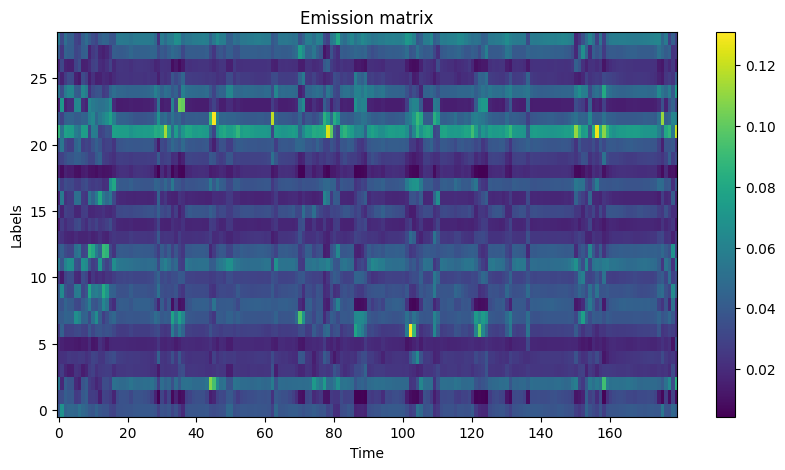

In [151]:
# TODO: apply the model to the waveform to compute the emission matrix, print its shape and plot it

with torch.inference_mode():
    emission_matrix = model(waveform)

print(emission_matrix.shape)

plt.figure(figsize=(10, 5))
plt.imshow(emission_matrix[0].detach().numpy().T, aspect='auto', origin='lower')
plt.xlabel('Time')
plt.ylabel('Labels')
plt.title('Emission matrix')
plt.colorbar()
plt.show()



In [152]:
# We provide a function to get a transcript from the emission matrix (similar to the greedy decoder from lab 1)
def transcript_from_emission(emission, labels):
    indices = torch.argmax(emission, dim=-1)  # take the most likely index at each time step
    indices = torch.unique_consecutive(indices, dim=-1) # remove duplicates
    indices = [i for i in indices if i != 0] # remove the blank token
    transcript = "".join([labels[i] for i in indices]) # convert integers back into characters
    transcript = transcript.lower()
    return transcript

# The transcript using a non-trained model should look bad
print(transcript_from_emission(emission_matrix[0], labels))

bkbikbliclvfbibkbevbvbibvbvzbni'bznvbvbnikb'bibvb'vblb


## Dataset

We now need to define the `Dataset` class, to efficiently load the speech data and true transcript (in the form of indices / integers).

<span style="color:red"> **Exercise 2**</span>. Complete the `ASRdataset` class below (`__init__`, `__len__`, and `__getitem__` methods). In particular, the `__getitem__` method should return three outputs:
- `waveform`: a tensor containing the speech waveform
- `true_transcript`: the true transcript as per using the provided loading function
- `target_indices`: a tensor containing the integers corresponding to the transcript

The `__init__` method should make use of the `MAX_FILES` variable to limit the size of the dataset (for speed).

In [153]:
# ASR Dataset class
class ASRdataset(Dataset):
    def __init__(self, data_speech_dir, data_transc_dir, dico_labels, MAX_FILES=None):
        self.data_speech_dir = data_speech_dir
        self.data_transc_dir = data_transc_dir
        self.dico_labels = dico_labels
        self.MAX_FILES = MAX_FILES
        self.audio_files = self._find_files(data_speech_dir, MAX_FILES=MAX_FILES)
        self.transc_files = self._find_files(data_transc_dir, pattern='*.txt', MAX_FILES=MAX_FILES)

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, index):
        if self.MAX_FILES is not None and index >= self.MAX_FILES:
            raise IndexError
        audio_file = self.audio_files[index]
        audio_file_path = os.path.join(self.data_speech_dir, audio_file)
        waveform, sr = torchaudio.load(audio_file_path, channels_first=True)

        transc_file = audio_file.replace('wav', 'txt')
        transc_file_path = os.path.join(self.data_transc_dir, transc_file)
        true_transcript = get_true_transcript(transc_file_path)

        target_indices = [self.dico_labels[c] for c in true_transcript]
        target_indices = torch.tensor(target_indices, dtype=torch.long)

        return waveform, true_transcript, target_indices


    def _find_files(self, directory, pattern='*.wav', MAX_FILES=None):
        """Recursively finds all files matching the pattern."""
        files = []
        for root, _, filenames in os.walk(directory):
            for filename in fnmatch.filter(filenames, pattern):
                files.append(filename)
        files = sorted(files)
        # Limit the number of files using the MAX_FILES parameter
        if self.MAX_FILES is not None:
            files = files[:self.MAX_FILES]
        return files


In [154]:
# Instanciate the ASR dataset and print its length
asrdataset = ASRdataset(data_speech_dir, data_transc_dir, dico_labels, MAX_FILES=MAX_FILES)
print('Dataset length:', len(asrdataset))

# Get the first data sample, and print some information
waveform, true_transcript, target_indices = asrdataset[0]
print(waveform.dtype, waveform.shape)
print(true_transcript)
print(target_indices)

Dataset length: 100
torch.float32 torch.Size([1, 70560])
angor|pain|painful|to|hear
tensor([ 4,  6, 18,  5, 10,  1, 20,  4,  7,  6,  1, 20,  4,  7,  6, 17, 13, 12,
         1,  3,  5,  1,  8,  2,  4, 10])


In real-life applications (and as we usually do in the "Neural Networks" labs), we assemble the data samples into *batches* for efficiency. However, our data points here have different lenghts in general: two speech waveforms / two transcripts are not guaranteed to have the same duration / number of characters. Therefore, in such a case we need to customize the dataloader such that it performs some [padding operation](https://www.codefull.org/2018/11/use-pytorchs-dataloader-with-variable-length-sequences-for-lstm-gru/) in order to yield data samples of same length. However, to keep things simple in this lab, we skip this padding operation, and we do not work with batches but rather iterate over the dataset directly.

## Training with the CTC loss

For a given data sample in the dataset, we have:
- the emission matrix (log-probability of each character over time frames)
- the true transcript (represented as a list of integers corresponding to each character)

However, to train our network, we need to obtain an estimated transcript so that we can compute a loss between the true and estimated transcripts. This requires some post-processing of the emission matrix, but the good news is that we don't have to do it, the [CTC loss](https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html) handles that for us!

In lab 2 we have use the CTC algorithm to perform inference, but it can also be used as a loss function to train an ASR network. Not only the CTC loss handles the post-processing from the emission matrix, but its great advantage is that it performs alignment from input/output pairs of different lengths, so we don't have to explicitly align each character in the transcript with a time frame in the emission matrix.

In Pytorch, [CTC loss](https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html) is fed with the the emission matrix and the tensor containing target indices (corresponding to the true transcript). We also need to give it the input and target lengths explicitly: indeed, even though here we don't manipulate batches / we don't do padding, in general this would be the case so we need to let the function know what is the actual input/target length (before padding).

In [155]:
# Compute the emission matrix (not in inference mode such that we keep track of the gradients)
emission = model(waveform)
emission = emission[0] #remove the "batch" dimension (since here batch_size=1)

# Define the input and target lengths as tensors
T = emission.shape[0]
L = len(target_indices)
input_length = torch.tensor(T, dtype=torch.long)
target_length = torch.tensor(L, dtype=torch.long)

# Instanciate a loss object
ctc_loss = nn.CTCLoss()

# Compute the loss
loss = ctc_loss(emission, target_indices, input_length, target_length)
print(loss.item())

# Compute the gradients
loss.backward()

-5.046385765075684


<span style="color:red"> **Exercise 3**</span>. Write the training function `training_wav2vecASR` to train the model. It is similar to what we usually do in the Neural Networks labs, although here we do not build batches of data (thus we don't need a `Dataloader` object). Instead, we directly iterate over the `Dataset`. The training function uses an Adam optimizer, and no validation.

In [156]:
def training_wav2vecASR(model, train_loader, num_epochs, loss_fn, learning_rate):
    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)

    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()

    # Define the optimizer
    optimizer = torch.optim.Adam(model_tr.parameters(), lr=learning_rate)


    # Initialize a list for storing the training loss over epochs
    train_losses = []

    # Training loop
    for epoch in range(num_epochs):

        # Initialize the training loss for the current epoch
        tr_loss = 0

        # Loop over the training set
        for i, (waveform, true_transcript, target_indices) in enumerate(train_loader):

            # Compute the emission matrix
            emission = model_tr(waveform)
            emission = emission[0]
            # Define the input and target lengths as tensors
            T = emission.shape[0]
            L = len(target_indices)
            input_length = torch.tensor(T, dtype=torch.long)
            target_length = torch.tensor(L, dtype=torch.long)

            # Compute the loss
            loss = loss_fn(emission, target_indices, input_length, target_length)
            print(loss.item())

            optimizer.zero_grad()

            # Compute the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Add the loss to the epoch loss
            tr_loss += loss.item()

        # Compute the average loss over the epoch
        tr_loss /= len(train_loader)

        # Store the average loss
        train_losses.append(tr_loss)

        # Print the average loss
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {tr_loss}")

    return model_tr, train_losses


In [157]:
# Training parameters (only one epoch for speed)
num_epochs = 1
learning_rate = 0.1
loss_fn = nn.CTCLoss()

model_tr, train_losses = training_wav2vecASR(model, asrdataset, num_epochs, loss_fn, learning_rate)

-5.04835319519043
-4.79306697845459
-13.32648754119873
-7.246302127838135
-8.639681816101074
-8.300421714782715
-10.767064094543457
-10.55659294128418
-8.656609535217285
-21.580568313598633
-7.361466884613037
-4.238164901733398
-6.623748302459717
-4.34070348739624
-3.9771718978881836
-3.994398832321167
-10.934734344482422
-3.936495304107666
-4.177453517913818
-3.6346752643585205
-4.0215864181518555
-3.6606345176696777
-6.095983505249023
-7.939322471618652
-4.839008808135986
-6.8239827156066895
-5.57454776763916
-4.521894454956055
-4.751573085784912
-6.001677989959717
-5.177074909210205
-6.8307037353515625
-5.211999416351318
-4.488745212554932
-4.437160968780518
-4.322038650512695
-3.472696304321289
-4.870884418487549
-6.1103129386901855
-4.879040241241455
-4.967413425445557
-3.9265708923339844
-6.497711658477783
-3.823300361633301
-6.521557331085205
-4.8317131996154785
-4.3641438484191895
-3.663473606109619
-6.488637924194336
-5.113731861114502
-4.735828399658203
-4.756128787994385
-2.

## Overfitting on one sample

We observed above that training is slow: this is because the wav2vec model is rather large so the forward pass takes some time (even though the gradients are not tracked), and also because we did not assemble data into batches.

Nonetheless, we can assess that our training pipeline works properly by conducting training on a unique sample, and checking the transcript on the same sample. This technique (= overfitting on one sample) is useful to "crash test" if everything runs and if our model / training pipeline has any chance to work on a larger dataset.

<span style="color:red"> **Exercise 4**</span>. Instanciate a model from scratch, freeze the wav2part, and initialize the classification layer. Build a dataset made up of 1 sample (use the `MAX_FILES` parameter), and conduct training for 50 epoch using this dataset. Once the model is trained, compute the emission matrix from this sample's waveform and the estimated transcript. Display the true and estimated transcripts. Also do the same on another sentence so that you can assess that the model is not able to generalize properly.

In [158]:
overfit_model = Wav2vecASR(output_size)

# Freeze the wav2vec part of the model
freeze_params(overfit_model.feature_extractor)

# Initialize the classification layer
init_params(overfit_model.linear_classifier)

overfit_dataset = ASRdataset(data_speech_dir, data_transc_dir, dico_labels, MAX_FILES=1)

overfit_num_epochs = 50
overfit_learning_rate = 0.1
overfit_loss_fn = nn.CTCLoss()

model_overfit, overfit_train_losses = training_wav2vecASR(overfit_model, overfit_dataset, overfit_num_epochs, overfit_loss_fn, overfit_learning_rate)

-5.04835319519043
Epoch 1/50, Loss: -5.04835319519043
-6.6214599609375
Epoch 2/50, Loss: -6.6214599609375
-9.813535690307617
Epoch 3/50, Loss: -9.813535690307617
-10.572391510009766
Epoch 4/50, Loss: -10.572391510009766
-10.673407554626465
Epoch 5/50, Loss: -10.673407554626465
-10.829733848571777
Epoch 6/50, Loss: -10.829733848571777
-10.829981803894043
Epoch 7/50, Loss: -10.829981803894043
-10.829985618591309
Epoch 8/50, Loss: -10.829985618591309
-10.829985618591309
Epoch 9/50, Loss: -10.829985618591309
-10.829985618591309
Epoch 10/50, Loss: -10.829985618591309
-10.829985618591309
Epoch 11/50, Loss: -10.829985618591309
-10.829985618591309
Epoch 12/50, Loss: -10.829985618591309
-10.829985618591309
Epoch 13/50, Loss: -10.829985618591309
-10.829985618591309
Epoch 14/50, Loss: -10.829985618591309
-10.829985618591309
Epoch 15/50, Loss: -10.829985618591309
-10.829985618591309
Epoch 16/50, Loss: -10.829985618591309
-10.829985618591309
Epoch 17/50, Loss: -10.829985618591309
-10.82998561859130

torch.Size([1, 220, 29])


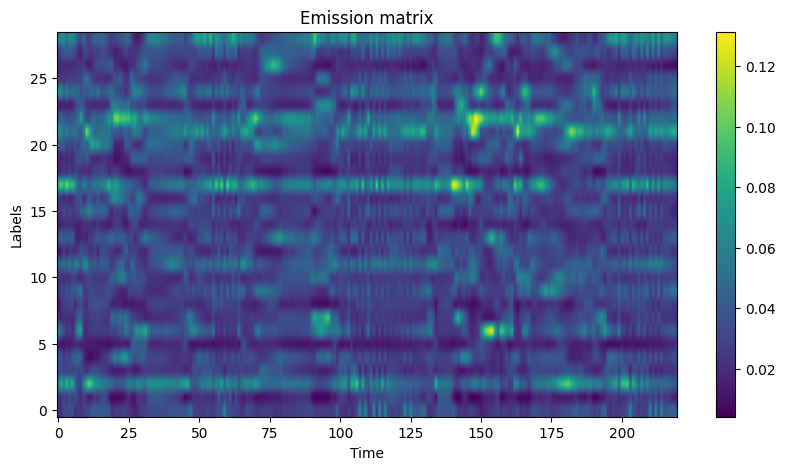

In [159]:
# Compute the emission matrix for the overfit sample
overfit_sample = overfit_dataset[0][0]

with torch.inference_mode():
    emission_matrix = model(overfit_sample)

print(emission_matrix.shape)

plt.figure(figsize=(10, 5))
plt.imshow(emission_matrix[0].detach().numpy().T, aspect='auto', origin='lower')
plt.xlabel('Time')
plt.ylabel('Labels')
plt.title('Emission matrix')
plt.colorbar()
plt.show()

In [160]:
# True transcript for the overfit sample
print(overfit_dataset[0][1])

# Estimated transcript for the overfit sample
print(transcript_from_emission(emission_matrix[0], labels))

angor|pain|painful|to|hear
fnvebepfvnvebnbzbzfzvfbfzfvbfvfjuvfvzinizdbfbzvezebfbvfbfbfbfzfzfbfbfdfvbvnznvfbv'bvqebe'binbezvebfzvfvfbzbzbzb


torch.Size([1, 154, 29])


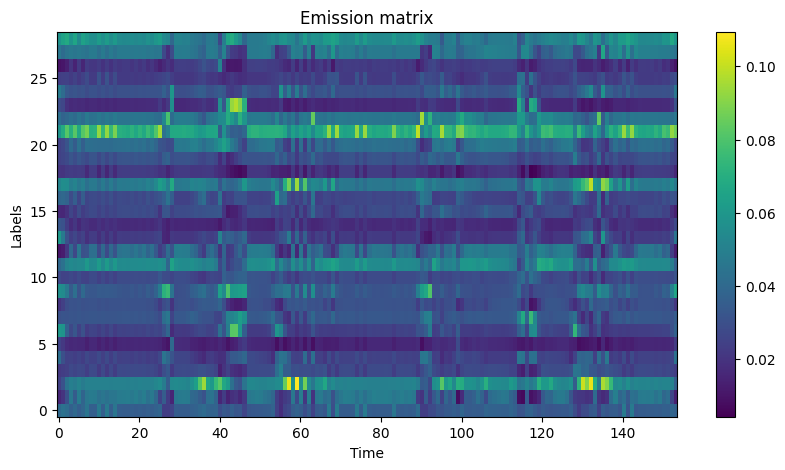

In [161]:
# Compute the emission matrix for another sample
another_sample = asrdataset[2][0]

with torch.inference_mode():
    emission_matrix = model(another_sample)

print(emission_matrix.shape)

plt.figure(figsize=(10, 5))
plt.imshow(emission_matrix[0].detach().numpy().T, aspect='auto', origin='lower')
plt.xlabel('Time')
plt.ylabel('Labels')
plt.title('Emission matrix')
plt.colorbar()
plt.show()

In [162]:
# True transcript
print(asrdataset[2][1])

# Estimated transcript
print(transcript_from_emission(emission_matrix[0], labels))

hedge|a|fence
ubsvfbebeskbebebebvbvsbkibikebnbeveb


In [163]:
# Comment on the results: I still get really bad results with the model, even after training it to overfit on a single sample for 50 epochs.